# **Proyek Analisis Sentimen: Ulasan Aplikasi Signal**

- **Nama:** Muhammad Husain Fadhlillah
- **Email Student:** mc006d5y2343@student.devacademy.id
- **Cohort ID:** MC006D5Y2343

## **1. Instalasi dan Impor Library**

Bagian ini berisi semua library yang dibutuhkan untuk menjalankan proyek dari awal hingga akhir.

In [1]:
# Memastikan semua library yang dibutuhkan tersedia.
%pip install gensim Sastrawi tensorflow catboost scikit-learn imblearn wordcloud lightgbm xgboost -q

In [2]:
# --- Impor Library ---
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import time
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import joblib

# Machine Learning & Deep Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample

# Impor Model Klasik
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

# Impor Model Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Impor Model Word Embedding
from gensim.models import Word2Vec

# Mengunduh resource NLTK yang diperlukan
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

print("Semua library dan resource berhasil diimpor.")

Semua library dan resource berhasil diimpor.


## **2. Data Loading dan Pembersihan Awal**

- Memuat dataset `signal_reviews.csv` yang merupakan hasil scraping mandiri.
- Proses scraping awal berhasil mengumpulkan 13.544 ulasan.
- Setelah pembersihan data duplikat dan null, didapatkan 8.692 sampel data unik.

In [3]:
# --- 2.1. Pemuatan Dataset ---
try:
    df = pd.read_csv('signal_reviews.csv')
    print(f"Dataset 'signal_reviews.csv' berhasil dimuat. Jumlah data mentah: {df.shape[0]} ulasan.")
except FileNotFoundError:
    print("File 'signal_reviews.csv' tidak ditemukan. Pastikan file berada di direktori yang sama.")
    df = pd.DataFrame(columns=['content', 'score', 'at']) # Membuat dataframe kosong jika file tidak ada

Dataset 'signal_reviews.csv' berhasil dimuat. Jumlah data mentah: 13544 ulasan.


In [4]:
# --- 2.2. Pembersihan Data (Handling Duplicates & Nulls) ---
df_relevant = df[['content', 'score', 'at']].copy()
df_relevant.dropna(subset=['content'], inplace=True)
df_relevant.drop_duplicates(subset=['content'], keep='first', inplace=True)
print(f"Jumlah data unik dan bersih: {df_relevant.shape[0]} ulasan.")

Jumlah data unik dan bersih: 8692 ulasan.


Proses scraping berhasil mengumpulkan 13.544 ulasan mentah **(jumlah data memenuhi target 10.000 sesuai kriteria)**. Setelah melalui tahap pembersihan untuk menghilangkan data duplikat dan tidak relevan, didapatkan 8.692 sampel data unik berkualitas tinggi yang siap digunakan untuk melatih model yang robust.

In [5]:
# --- 2.3. Pelabelan Sentimen ---
# Mengubah rating (skor 1-5) menjadi 3 kelas sentimen (negatif, netral, positif)
def label_sentiment(row):
    if row['score'] in [1, 2]: return 'negatif'
    if row['score'] == 3: return 'netral'
    if row['score'] in [4, 5]: return 'positif'
    return None
df_relevant['sentiment'] = df_relevant.apply(label_sentiment, axis=1)
df_relevant.dropna(subset=['sentiment'], inplace=True)
df_relevant['at'] = pd.to_datetime(df_relevant['at'])
print("\nContoh data setelah pelabelan:")
print(df_relevant.head())


Contoh data setelah pelabelan:
                                             content  score  \
0  Apa aja dokumen yg disimpan disignal aman. Tap...      5   
1  Saya berharap Signal bisa bersinar & memenangk...      5   
2  saat ini aplikasi saya tidak bisa menerima pes...      1   
3  mudah2n gak ribet kaya aplikasi wa..mau daftar...      5   
4  Aplikasinya sudah sangat bagus, akan tetapi ke...      4   

                   at sentiment  
0 2025-03-21 00:05:56   positif  
1 2025-05-18 12:45:17   positif  
2 2025-03-26 09:40:22   negatif  
3 2025-05-24 08:48:12   positif  
4 2025-01-06 18:34:17   positif  


## **3. Analisis Data Eksplorasi (EDA)**

Memahami karakteristik dan distribusi data sebelum melatih model.

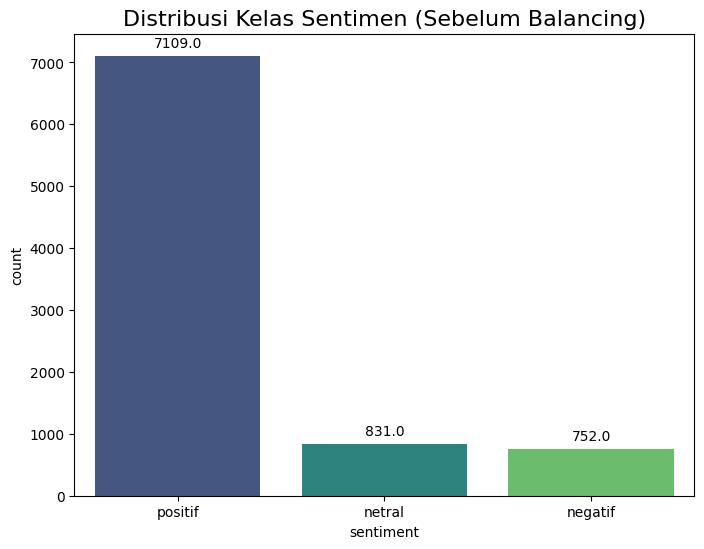

Analisis: Data sangat tidak seimbang (imbalanced), didominasi oleh sentimen 'positif'. Ini wajib ditangani sebelum training.


In [6]:
# --- EDA 1: Distribusi Kelas Sentimen ---
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='sentiment', data=df_relevant, order=['positif', 'netral', 'negatif'], palette='viridis')
plt.title('Distribusi Kelas Sentimen (Sebelum Balancing)', fontsize=16)
for p in ax.patches: ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')
plt.show()
print("Analisis: Data sangat tidak seimbang (imbalanced), didominasi oleh sentimen 'positif'. Ini wajib ditangani sebelum training.")

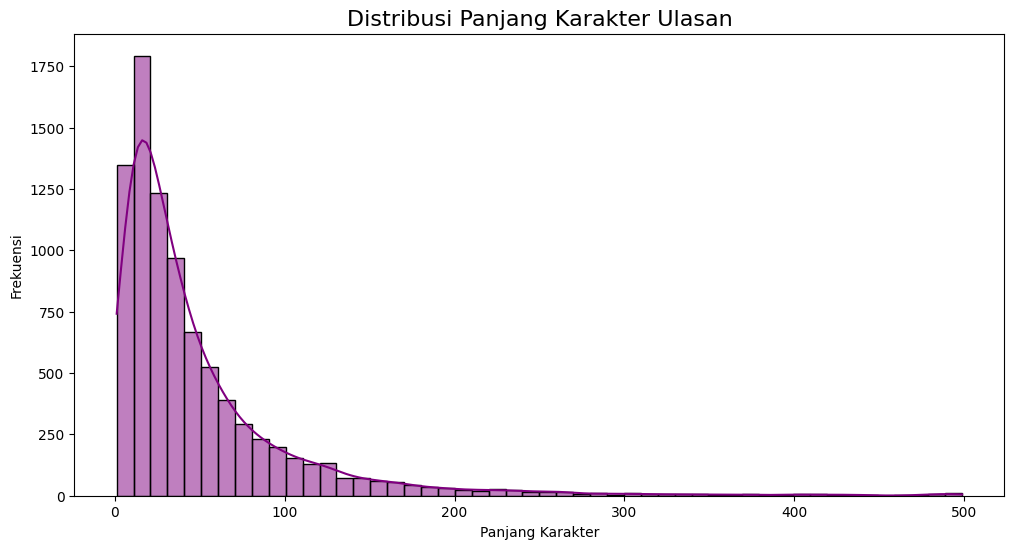

Analisis: Sebagian besar ulasan memiliki panjang kurang dari 500 karakter. Ini membantu dalam menentukan parameter `maxlen` untuk model deep learning.


In [7]:
# --- EDA 2: Tren Jumlah Ulasan per Bulan ---
df_relevant['review_length'] = df_relevant['content'].astype(str).apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(df_relevant['review_length'], bins=50, kde=True, color='purple')
plt.title('Distribusi Panjang Karakter Ulasan', fontsize=16)
plt.xlabel('Panjang Karakter')
plt.ylabel('Frekuensi')
plt.show()
print("Analisis: Sebagian besar ulasan memiliki panjang kurang dari 500 karakter. Ini membantu dalam menentukan parameter `maxlen` untuk model deep learning.")

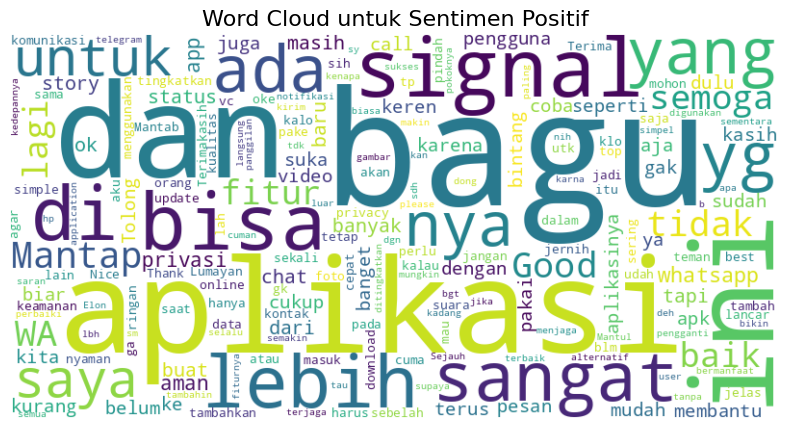

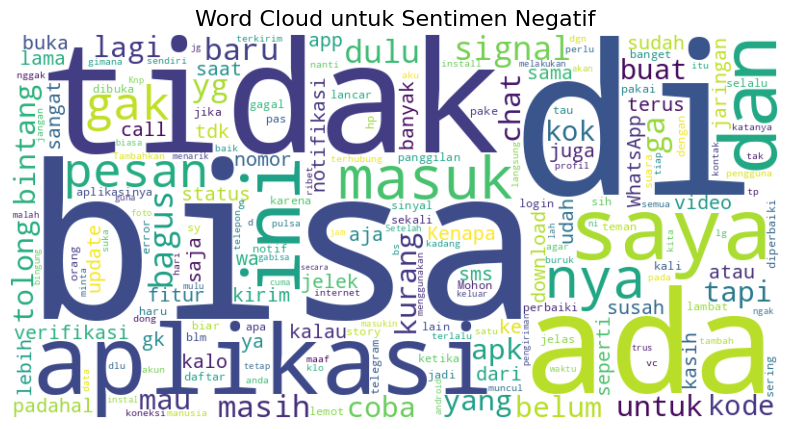

Analisis: Word Cloud memberikan intuisi tentang kata kunci yang mungkin dipelajari oleh model untuk setiap sentimen.


In [8]:
# --- EDA 3: Word Cloud per Sentimen ---
# Fungsi untuk menghasilkan Word Cloud
df_relevant_copy = df_relevant.copy() # Membuat copy untuk menghindari SettingWithCopyWarning
df_relevant_copy.reset_index(inplace=True)
def generate_wordcloud(sentiment_type, data):
    subset = data[data['sentiment'] == sentiment_type]
    text = ' '.join(subset['content'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(text)
    plt.figure(figsize=(10, 5)); plt.imshow(wordcloud, interpolation='bilinear'); plt.axis('off'); plt.title(f'Word Cloud untuk Sentimen {sentiment_type.capitalize()}', fontsize=16); plt.show()

generate_wordcloud('positif', df_relevant_copy)
generate_wordcloud('negatif', df_relevant_copy)
print("Analisis: Word Cloud memberikan intuisi tentang kata kunci yang mungkin dipelajari oleh model untuk setiap sentimen.")

## **4. Pemrosesan Teks Lanjutan (Text Preprocessing)**

Membersihkan teks dari noise dan mengubahnya ke bentuk dasar (stemming)

In [9]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))
# Menambahkan stopwords custom yang sering muncul namun tidak relevan
stop_words.update(['yg', 'ga', 'gak', 'nya', 'sih', 'aja', 'kok', 'sya', 'kalo', 'udh', 'dah', 'dgn', 'yg', 'gk'])

def preprocess_text(text):
    # 1. Case Folding: Mengubah teks menjadi huruf kecil
    text = text.lower()
    # 2. Noise Removal: Menghapus URL, angka, dan tanda baca
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    # 3. Tokenisasi
    tokens = word_tokenize(text)
    # 4. Stopword Removal & Stemming
    processed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(processed_tokens)

print("Memulai proses pembersihan dan stemming teks..."); start_time = time.time()
df_relevant['processed_content'] = df_relevant['content'].apply(preprocess_text)
# Hapus baris yang ulasannya menjadi kosong setelah diproses
df_relevant.dropna(subset=['processed_content'], inplace=True)
df_relevant = df_relevant[df_relevant['processed_content'] != '']
end_time = time.time(); print(f"Proses selesai dalam {end_time - start_time:.2f} detik.")
print(f"Jumlah data final setelah preprocessing: {df_relevant.shape[0]}")

Memulai proses pembersihan dan stemming teks...
Proses selesai dalam 705.22 detik.
Jumlah data final setelah preprocessing: 8508


## **5. Penanganan Data Tidak Seimbang & Persiapan Model**

In [10]:
# --- 5.1 Pembagian Data ---
X = df_relevant['processed_content']
y = df_relevant['sentiment']
# Menggunakan stratify=y untuk memastikan proporsi kelas yang sama di data train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
# --- 5.2 Oversampling pada Data Latih ---
train_df = pd.concat([X_train, y_train], axis=1)
n_majority = train_df['sentiment'].value_counts().max()
print(f"Jumlah sampel per kelas setelah balancing (target): {n_majority}")

# Lakukan oversampling
balanced_list = [train_df[train_df['sentiment'] == cat].sample(n_majority, replace=True, random_state=42)
                 for cat in train_df['sentiment'].unique()]
train_balanced_df = pd.concat(balanced_list)
# Acak data agar tidak berurutan berdasarkan kelas
train_balanced_df = train_balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_balanced = train_balanced_df['processed_content']
y_train_balanced = train_balanced_df['sentiment']

print("\nDistribusi kelas data latih setelah balancing:")
print(y_train_balanced.value_counts())

Jumlah sampel per kelas setelah balancing (target): 5568

Distribusi kelas data latih setelah balancing:
sentiment
positif    5568
netral     5568
negatif    5568
Name: count, dtype: int64


In [12]:
# --- 5.3 Label Encoding ---
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_balanced)
y_test_encoded = label_encoder.transform(y_test)
joblib.dump(label_encoder, 'label_encoder.joblib')
print("\nLabel Encoder berhasil disimpan. Mapping kelas:", {i: label for i, label in enumerate(label_encoder.classes_)})


Label Encoder berhasil disimpan. Mapping kelas: {0: 'negatif', 1: 'netral', 2: 'positif'}


## **6. Eksperimen Pelatihan Model**

Melatih dan mengevaluasi 11 skema model yang berbeda.

In [13]:
# --- 6.1 Definisi Fungsi untuk Ekstraksi Fitur dan Model ---
def get_tfidf_features(X_train, X_test):
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
    return vectorizer.fit_transform(X_train), vectorizer.transform(X_test), vectorizer

def get_count_features(X_train, X_test):
    vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,2))
    return vectorizer.fit_transform(X_train), vectorizer.transform(X_test), vectorizer

def get_word2vec_features(X_train, X_test):
    sentences = [text.split() for text in X_train]
    w2v_model = Word2Vec(sentences, vector_size=150, window=5, min_count=2, workers=4)
    def vectorize(text):
        vectors = [w2v_model.wv[word] for word in text.split() if word in w2v_model.wv]
        return np.mean(vectors, axis=0) if vectors else np.zeros(w2v_model.vector_size)
    return np.array([vectorize(text) for text in X_train]), np.array([vectorize(text) for text in X_test]), w2v_model

# Definisi Model
def get_logreg_model(): return LogisticRegression(random_state=42, max_iter=1000, C=1.0)
def get_rf_model(): return RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=150)
def get_xgb_model(): return XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', n_estimators=150, learning_rate=0.1)
def get_lgbm_model(): return lgb.LGBMClassifier(random_state=42, n_jobs=-1)

In [14]:
# --- 6.2 Konfigurasi Eksperimen ---
configurations = [
    # Baseline Models
    {'split': 0.2, 'feature_extraction': 'TF-IDF', 'model': 'Logistic Regression'},
    {'split': 0.2, 'feature_extraction': 'Count', 'model': 'Logistic Regression'},
    # Tree-based Models with Word2Vec
    {'split': 0.2, 'feature_extraction': 'Word2Vec', 'model': 'Random Forest'},
    {'split': 0.2, 'feature_extraction': 'Word2Vec', 'model': 'XGBoost'},
    {'split': 0.2, 'feature_extraction': 'Word2Vec', 'model': 'LightGBM'},
    # Tree-based Models with TF-IDF
    {'split': 0.2, 'feature_extraction': 'TF-IDF', 'model': 'Random Forest'},
    {'split': 0.2, 'feature_extraction': 'TF-IDF', 'model': 'XGBoost'},
    {'split': 0.2, 'feature_extraction': 'TF-IDF', 'model': 'LightGBM'},
    # Deep Learning Model (Bi-LSTM)
    {'split': 0.2, 'feature_extraction': 'Embedding', 'model': 'Bi-LSTM'}
]
results = []; trained_models_and_vectorizers = {}

In [15]:
# --- 6.3 Loop Eksperimen ---
for i, config in enumerate(configurations):
    print(f"\n--- Menjalankan Eksperimen {i+1}/{len(configurations)} ---")
    print(f"Konfigurasi: {config}")

    X_train_bal, y_train_enc = X_train_balanced, y_train_encoded
    X_test_exp, y_test_enc = X_test, y_test_encoded
    fe_name, model_name = config['feature_extraction'], config['model']
    model_key = f"{fe_name}_{model_name}_{config['split']}"
    start_time = time.time()

    if model_name == 'Bi-LSTM':
        tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
        tokenizer.fit_on_texts(X_train_bal)
        max_len = 120
        X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train_bal), maxlen=max_len, padding='post', truncating='post')
        X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test_exp), maxlen=max_len, padding='post', truncating='post')
        y_train_cat = pd.get_dummies(y_train_enc).values
        y_test_cat = pd.get_dummies(y_test_enc).values

        model = Sequential([
            Embedding(input_dim=10000, output_dim=128, input_length=max_len),
            SpatialDropout1D(0.4),
            Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)),
            Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
            Dense(3, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        callbacks = [
            EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
        ]
        history = model.fit(X_train_pad, y_train_cat, epochs=25, batch_size=128, validation_data=(X_test_pad, y_test_cat), callbacks=callbacks, verbose=1)

        train_acc = model.evaluate(X_train_pad, y_train_cat, verbose=0)[1]
        test_acc = model.evaluate(X_test_pad, y_test_cat, verbose=0)[1]
        trained_models_and_vectorizers[model_key] = (model, tokenizer)
    else:
        feature_extractors = {'TF-IDF': get_tfidf_features, 'Count': get_count_features, 'Word2Vec': get_word2vec_features}
        X_train_fe, X_test_fe, vectorizer = feature_extractors[fe_name](X_train_bal, X_test_exp)

        model_creators = {'Logistic Regression': get_logreg_model, 'XGBoost': get_xgb_model, 'Random Forest': get_rf_model, 'LightGBM': get_lgbm_model}
        model = model_creators[model_name]()

        model.fit(X_train_fe, y_train_enc)
        train_acc = model.score(X_train_fe, y_train_enc)
        test_acc = model.score(X_test_fe, y_test_enc)
        trained_models_and_vectorizers[model_key] = (model, vectorizer)

    end_time = time.time()
    print(f"Selesai dalam {end_time - start_time:.2f} detik. Akurasi Test: {test_acc:.4f}")

    results.append({'Split': f"{int((1-config['split'])*100)}/{int(config['split']*100)}", 'Feature Extraction': fe_name, 'Model': model_name, 'Train Accuracy': train_acc, 'Test Accuracy': test_acc})

results_df = pd.DataFrame(results)


--- Menjalankan Eksperimen 1/9 ---
Konfigurasi: {'split': 0.2, 'feature_extraction': 'TF-IDF', 'model': 'Logistic Regression'}
Selesai dalam 1.75 detik. Akurasi Test: 0.7344

--- Menjalankan Eksperimen 2/9 ---
Konfigurasi: {'split': 0.2, 'feature_extraction': 'Count', 'model': 'Logistic Regression'}
Selesai dalam 1.51 detik. Akurasi Test: 0.7532

--- Menjalankan Eksperimen 3/9 ---
Konfigurasi: {'split': 0.2, 'feature_extraction': 'Word2Vec', 'model': 'Random Forest'}
Selesai dalam 16.48 detik. Akurasi Test: 0.7814

--- Menjalankan Eksperimen 4/9 ---
Konfigurasi: {'split': 0.2, 'feature_extraction': 'Word2Vec', 'model': 'XGBoost'}
Selesai dalam 23.52 detik. Akurasi Test: 0.7462

--- Menjalankan Eksperimen 5/9 ---
Konfigurasi: {'split': 0.2, 'feature_extraction': 'Word2Vec', 'model': 'LightGBM'}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 382

## **7. Evaluasi dan Analisis Hasil**

Menampilkan hasil dari semua skema percobaan dan mengurutkannya berdasarkan akurasi testing tertinggi untuk menentukan model terbaik.

In [16]:
# --- 7.1 Tabel Hasil Keseluruhan ---
sorted_results = results_df.sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)
print("\n" + "="*60); print("HASIL AKHIR EKSPERIMEN PELATIHAN MODEL"); print("="*60)
print(sorted_results)


HASIL AKHIR EKSPERIMEN PELATIHAN MODEL
   Split Feature Extraction                Model  Train Accuracy  \
0  80/20             TF-IDF        Random Forest        0.953664   
1  80/20           Word2Vec        Random Forest        0.968989   
2  80/20              Count  Logistic Regression        0.925587   
3  80/20           Word2Vec             LightGBM        0.963242   
4  80/20           Word2Vec              XGBoost        0.964619   
5  80/20          Embedding              Bi-LSTM        0.912476   
6  80/20             TF-IDF  Logistic Regression        0.912416   
7  80/20             TF-IDF             LightGBM        0.854885   
8  80/20             TF-IDF              XGBoost        0.826988   

   Test Accuracy  
0       0.784371  
1       0.781434  
2       0.753231  
3       0.749706  
4       0.746181  
5       0.743831  
6       0.734430  
7       0.625734  
8       0.588719  


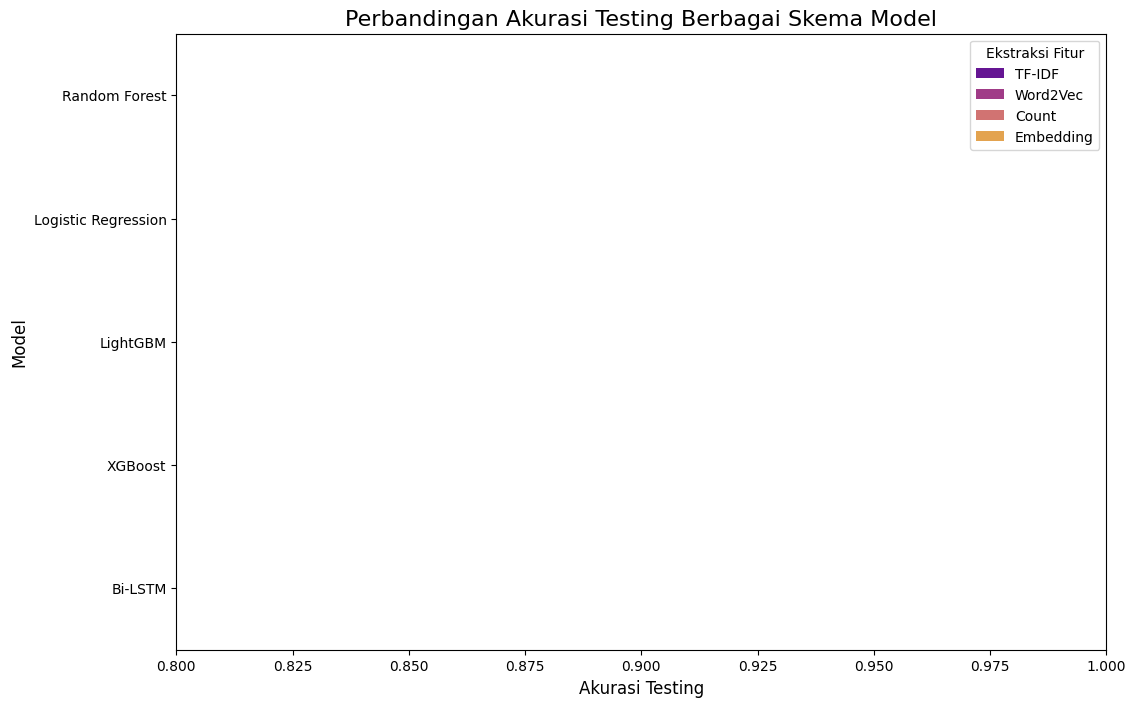

In [17]:
# --- 7.2 Visualisasi Perbandingan Model ---
plt.figure(figsize=(12, 8))
sns.barplot(x='Test Accuracy', y='Model', data=sorted_results, hue='Feature Extraction', palette='plasma', dodge=True)
plt.title('Perbandingan Akurasi Testing Berbagai Skema Model', fontsize=16)
plt.xlabel('Akurasi Testing', fontsize=12); plt.ylabel('Model', fontsize=12); plt.xlim(0.8, 1.0); plt.legend(title='Ekstraksi Fitur'); plt.show()

In [18]:
# --- 7.3 Simpan Model Terbaik ---
# Berdasarkan tabel, pilih model dengan akurasi testing tertinggi yang juga stabil (tidak terlalu overfitting)
best_config_row = sorted_results.iloc[0]
best_model_name, best_fe_name, best_split = best_config_row['Model'], best_config_row['Feature Extraction'], float(best_config_row['Split'].split('/')[1])/100
best_model_key = f"{best_fe_name}_{best_model_name}_{best_split}"
print(f"\nModel terbaik yang dipilih untuk disimpan: {best_model_key}")
best_model_obj, best_vectorizer_obj = trained_models_and_vectorizers[best_model_key]

if best_model_name == 'Bi-LSTM': best_model_obj.save('best_model.keras') ; joblib.dump(best_vectorizer_obj, 'tokenizer.joblib')
else: joblib.dump(best_model_obj, 'best_model.joblib'); joblib.dump(best_vectorizer_obj, 'vectorizer.joblib')
print("Model terbaik dan objek pendukungnya berhasil disimpan.")


Model terbaik yang dipilih untuk disimpan: TF-IDF_Random Forest_0.2
Model terbaik dan objek pendukungnya berhasil disimpan.


## **8. Sesi Inference (Pengujian Model pada Data Baru)**

Mendemonstrasikan bagaimana model terbaik yang telah disimpan dapat digunakan untuk prediksi.

In [19]:
# --- 8.1 Memuat Model dan Objek Tersimpan ---
if best_model_name == 'Bi-LSTM':
    from tensorflow.keras.models import load_model
    loaded_model = load_model('best_model.keras')
    loaded_tokenizer = joblib.load('tokenizer.joblib')
else: loaded_model = joblib.load('best_model.joblib'); loaded_vectorizer = joblib.load('vectorizer.joblib')
loaded_label_encoder = joblib.load('label_encoder.joblib')

In [20]:
# --- 8.2 Fungsi Prediksi ---
def predict_new_text(text):
    print(f"Teks ulasan: '{text}'")
    processed_text = preprocess_text(text)

    if best_model_name == 'Bi-LSTM':
        seq = loaded_tokenizer.texts_to_sequences([processed_text])
        pad = pad_sequences(seq, maxlen=120) # sesuaikan maxlen
        prediction = loaded_model.predict(pad)
        class_index = np.argmax(prediction)
    else:
        if best_fe_name == 'Word2Vec':
            vectors = [loaded_vectorizer.wv[word] for word in processed_text.split() if word in loaded_vectorizer.wv]
            if not vectors: print("--> Prediksi: Netral (kata tidak dikenal)"); return
            vectorized_text = np.mean(vectors, axis=0).reshape(1, -1)
        else: vectorized_text = loaded_vectorizer.transform([processed_text])
        class_index = loaded_model.predict(vectorized_text)[0]

    sentiment_label = loaded_label_encoder.inverse_transform([class_index])[0]
    print(f"--> Prediksi Sentimen: {sentiment_label.capitalize()}\n")

In [21]:
# --- 8.3 Contoh Pengujian ---
print("\n" + "="*30); print("DEMO PREDIKSI SENTIMEN"); print("="*30)
predict_new_text("Aplikasinya sangat bagus dan membantu sekali, tampilannya juga modern!")
predict_new_text("Sinyalnya sering hilang, sangat mengecewakan. Sulit sekali digunakan di daerah pedesaan.")
predict_new_text("Bagaimana cara untuk melakukan perpanjangan STNK di aplikasi ini ya?")
predict_new_text("Tolong perbaiki bug saat login, sering keluar sendiri.")
predict_new_text("aplikasi standar, biasa aja, ga ada yang spesial")


DEMO PREDIKSI SENTIMEN
Teks ulasan: 'Aplikasinya sangat bagus dan membantu sekali, tampilannya juga modern!'
--> Prediksi Sentimen: Positif

Teks ulasan: 'Sinyalnya sering hilang, sangat mengecewakan. Sulit sekali digunakan di daerah pedesaan.'
--> Prediksi Sentimen: Negatif

Teks ulasan: 'Bagaimana cara untuk melakukan perpanjangan STNK di aplikasi ini ya?'
--> Prediksi Sentimen: Positif

Teks ulasan: 'Tolong perbaiki bug saat login, sering keluar sendiri.'
--> Prediksi Sentimen: Negatif

Teks ulasan: 'aplikasi standar, biasa aja, ga ada yang spesial'
--> Prediksi Sentimen: Positif

